In [ ]:
import os

USE_GPU = 1

if USE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES']='0'
else:
    os.environ['CUDA_VISIBLE_DEVICES']=''

import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
import pandas as pd
from functools import reduce
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import math
from keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt


column_names = [
    'ID', 'PARAM', 'TYPE', 'YEAR', 'DD',
    'Jan', 'Jan_SYM', 'Feb', 'Feb_SYM', 'Mar', 'Mar_SYM',
    'Apr', 'Apr_SYM', 'May', 'May_SYM', 'Jun', 'Jun_SYM',
    'Jul', 'Jul_SYM', 'Aug', 'Aug_SYM', 'Sep', 'Sep_SYM',
    'Oct', 'Oct_SYM', 'Nov', 'Nov_SYM', 'Dec', 'Dec_SYM'
]

MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

data = pd.read_csv('data/credit_hydrometric_data_all_stations.csv', skiprows=2, names=column_names)

In [ ]:
_02HB018 = data[data['ID'] == '02HB018'].reset_index(drop=True)

_02HB025 = data[data['ID'] == '02HB025'].reset_index(drop=True)

_02HB031 = data[data['ID'] == '02HB031'].reset_index(drop=True)

_02HB001 = data[data['ID'] == '02HB001'].reset_index(drop=True)

_02HB013 = data[data['ID'] == '02HB013'].reset_index(drop=True)

_02HB029 = data[data['ID'] == '02HB029'].reset_index(drop=True)  ### TARGET


In [ ]:
import pandas as pd
import calendar

def is_valid_date(year, month, day):
    try:
        m = calendar.monthrange(year, month)
        if day > m[1]:
            return False
        else:
            return True
    except Exception as e:
        print(e)
        return False


def split_by_param_1_2(df: pd.DataFrame):
    data1 = df[df['PARAM'] == 1].reset_index(drop=True)
    data2 = df[df['PARAM'] == 2].reset_index(drop=True)
    return data1, data2

def wateroffice_to_timeseries(df : pd.DataFrame):
    data_dict = {'timestamp': [], 'value': []}

    for i, row in df.iterrows():
        year = row['YEAR']
        day = row['DD']
        for month in MONTHS :
            if is_valid_date(year, MONTHS.index(month) + 1, day):

                timestamp = pd.Timestamp(f'{year}-{month}-{day}')
                val = df.at[i, f'{month}']
                data_dict['timestamp'].append(timestamp)
                data_dict['value'].append(val)

    new_data = pd.DataFrame(data_dict)
    return new_data


def merge_param_1_2(df_left : pd.DataFrame, df_right : pd.DataFrame):
    return pd.merge(df_left, df_right, on='timestamp', how='inner')



In [ ]:
_02HB018_1, _02HB018_2 = split_by_param_1_2(_02HB018)
_02HB025_1, _02HB025_2 = split_by_param_1_2(_02HB025)
_02HB031_1, _02HB031_2 = split_by_param_1_2(_02HB031)
_02HB001_1, _02HB001_2 = split_by_param_1_2(_02HB001)
_02HB013_1, _02HB013_2 = split_by_param_1_2(_02HB013)
_02HB029_1, _02HB029_2 = split_by_param_1_2(_02HB029)



In [ ]:
_02HB018_1_ts = wateroffice_to_timeseries(_02HB018_1).rename(columns={'value': 'discharge_02HB018'})
_02HB018_2_ts = wateroffice_to_timeseries(_02HB018_2).rename(columns={'value': 'water_level_02HB018'})
_02HB025_1_ts = wateroffice_to_timeseries(_02HB025_1).rename(columns={'value': 'discharge_02HB025'})
_02HB025_2_ts = wateroffice_to_timeseries(_02HB025_2).rename(columns={'value': 'water_level_02HB025'})
_02HB031_1_ts = wateroffice_to_timeseries(_02HB031_1).rename(columns={'value': 'discharge_02HB031'})
_02HB031_2_ts = wateroffice_to_timeseries(_02HB031_2).rename(columns={'value': 'water_level_02HB031'})
_02HB001_1_ts = wateroffice_to_timeseries(_02HB001_1).rename(columns={'value': 'discharge_02HB001'})
_02HB001_2_ts = wateroffice_to_timeseries(_02HB001_2).rename(columns={'value': 'water_level_02HB001'})
_02HB013_1_ts = wateroffice_to_timeseries(_02HB013_1).rename(columns={'value': 'discharge_02HB013'})
_02HB013_2_ts = wateroffice_to_timeseries(_02HB013_2).rename(columns={'value': 'water_level_02HB013'})
_02HB029_1_ts = wateroffice_to_timeseries(_02HB029_1).rename(columns={'value': 'discharge_02HB029'})
_02HB029_2_ts = wateroffice_to_timeseries(_02HB029_2).rename(columns={'value': 'water_level_02HB029'})

In [ ]:
def merge_param_1_2(df_left : pd.DataFrame, df_right : pd.DataFrame):
    return pd.merge(df_left, df_right, on='timestamp', how='inner')


def fill_na(df: pd.DataFrame):
    # if whole row is NA, drop it, otherwise fill it with ffill and bfill
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    return df


In [ ]:
merged_02HB018 = merge_param_1_2(_02HB018_1_ts, _02HB018_2_ts)
merged_02HB025 = merge_param_1_2(_02HB025_1_ts, _02HB025_2_ts)
merged_02HB031 = merge_param_1_2(_02HB031_1_ts, _02HB031_2_ts)
merged_02HB001 = merge_param_1_2(_02HB001_1_ts, _02HB001_2_ts)
merged_02HB013 = merge_param_1_2(_02HB013_1_ts, _02HB013_2_ts)
merged_02HB029 = merge_param_1_2(_02HB029_1_ts, _02HB029_2_ts)

In [ ]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['timestamp'],
                                            how='outer'), [merged_02HB018, merged_02HB025, merged_02HB031, merged_02HB001, merged_02HB013, merged_02HB029])

In [ ]:
print(df_merged['timestamp'].diff().dt.days.unique())

In [ ]:
df_merged

In [ ]:
df_merged.set_index('timestamp', inplace=True)

df_merged = fill_na(df_merged)

In [ ]:
def add_lag_times(df: pd.DataFrame):
    lag_times = {
        '02HB018': 7,
        '02HB025': 5,
        '02HB031': 9,
        '02HB001': 8,
        '02HB013': 12
    }

    df = df_hourly.copy()

    for column in df_hourly.columns:
        for station, lag in lag_times.items():
            if station in column: 
                df[f'{column}_lagged'] = df[column].shift(lag)

    return df

def interpolate_hourly(df: pd.DataFrame):
    df_hourly = df.resample('1H').interpolate('linear')
    df_hourly = fill_na(df_hourly)
    return df_hourly

df_hourly = interpolate_hourly(df_merged)

df_hourly_lagged = add_lag_times(df_hourly)

df_hourly_lagged = fill_na(df_hourly_lagged)


In [ ]:
df_hourly

In [ ]:
df_hourly_lagged

In [ ]:
assert(len(df_merged.index.to_series().diff().dt.days.unique()) == 2)
assert(len(df_hourly.index.to_series().diff().dt.days.unique()) == 2)

In [ ]:
df_hourly.head(2)


In [ ]:
df_hourly_lagged

In [ ]:
df_merged

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, BatchNormalization, Bidirectional, LayerNormalization, ConvLSTM1D, Flatten, Dropout

def make_lstm(shape):

    #_LSTM = Sequential()
    #_LSTM.add(LSTM(100, return_sequences=True, input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2))
    #_LSTM.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    #_LSTM.add(Dense(1))
    _LSTM = Sequential()
    _LSTM.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(1,shape), dropout=0.2, recurrent_dropout=0.2)))
    _LSTM.add(BatchNormalization())
    _LSTM.add(Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2)))
    _LSTM.add(BatchNormalization())
    _LSTM.add(Dense(1))

    return _LSTM

def make_gru(shape):

    _GRU = Sequential()
    _GRU.add(GRU(50, return_sequences=True, input_shape=(1,shape), dropout=0.2))
    _GRU.add(LayerNormalization())
    _GRU.add(GRU(25, dropout=0.2))
    _GRU.add(Dense(1))

    return _GRU

def make_conv_lstm(shape):
    _CONVLSTM = Sequential()
    _CONVLSTM.add(ConvLSTM1D(filters=32, kernel_size=3, return_sequences=True, input_shape=(1,shape,1)))
    _CONVLSTM.add(BatchNormalization())
    #_CNNLSTM.add(ConvLSTM1D(filters=32, kernel_size=3, return_sequences=False))
    #_CNNLSTM.add(BatchNormalization())
    _CONVLSTM.add(Flatten())
    _CONVLSTM.add(Dense(50, activation='relu'))
    _CONVLSTM.add(Dropout(0.25))
    _CONVLSTM.add(Dense(1))

    return _CONVLSTM

In [ ]:
def prepare_dataset(df: pd.DataFrame):

    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df)

    def create_dataset(data :np.array, look_back=1):
        """
        set y as the next value in the sequence at the last index (water_level_02HB029)
        """
        X, Y = [], []
        for i in range(len(data) - look_back):
            a = data[i:(i + look_back), :]
            X.append(a)
            Y.append(data[i + look_back, -1])
        return np.array(X), np.array(Y) 
    
    look_back = 1
    X, Y = create_dataset(df_scaled, look_back)

    test_size = int(len(X) * 0.20)
    train_size = len(X) - test_size
    val_size = int(train_size * 0.20)

    X_train, X_val = X[:train_size-val_size], X[train_size-val_size:train_size]
    Y_train, Y_val = Y[:train_size-val_size], Y[train_size-val_size:train_size]
    X_test, Y_test = X[train_size:], Y[train_size:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler


In [41]:
# df_hourly_lagged as a string to file

with open('df_hourly_txt', 'w') as f:
    f.write(df_hourly_lagged.to_string())


# read in df_hourly_lagged from file
df = pd.read_csv('df_hourly_lagged.txt', sep='\s+', engine='python')


In [ ]:

# from string to dataframea
df_hourly_lagged = pd.read_csv(pd.compat.StringIO(s), sep='\s+')

In [36]:






datasets = {
    'merged': df_merged,
    'hourly': df_hourly,
    'lagged': df_hourly_lagged
}

models = {
    'LSTM': make_lstm,
    'GRU': make_gru,
    'ConvLSTM': make_conv_lstm
}

results = {}

for dataset_name, df in datasets.items():
    X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = prepare_dataset(df)
    for model_name, model_builder in models.items():
        
        model = model_builder(df.shape[1])

        model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
        history = model.fit(X_train, Y_train, epochs=100, batch_size=256, verbose=2,
                     validation_data=(X_val, Y_val))
        
        predictions = model.predict(X_test)
        predictions = scaler.inverse_transform(
            np.hstack((np.zeros((predictions.shape[0], df.shape[1]-1)), predictions)))

        Y_test = scaler.inverse_transform(
            np.hstack((np.zeros((Y_test.shape[0], df.shape[1]-1)), Y_test.reshape(-1, 1))))[:, -1]

        predictions = predictions[:, -1]

        rmse = math.sqrt(mean_squared_error(Y_test, predictions))
        mae = np.mean(np.abs(predictions - Y_test))
        
        results[(dataset_name, model_name)] = {
            'history': history.history,
            'rmse': rmse,
            'mae': mae,
            'predictions': predictions,
            'Y_test': Y_test, 
            'name': f'{dataset_name}_{model_name}'
        }


483/483 - 10s - loss: 5.1434e-05 - val_loss: 4.6446e-04 - 10s/epoch - 20ms/step
Epoch 64/100
483/483 - 10s - loss: 5.0236e-05 - val_loss: 5.1521e-04 - 10s/epoch - 21ms/step
Epoch 65/100
483/483 - 10s - loss: 6.1312e-05 - val_loss: 3.6236e-04 - 10s/epoch - 20ms/step
Epoch 66/100
483/483 - 10s - loss: 5.0341e-05 - val_loss: 5.9531e-04 - 10s/epoch - 20ms/step
Epoch 67/100
483/483 - 9s - loss: 5.6588e-05 - val_loss: 2.2619e-04 - 9s/epoch - 19ms/step
Epoch 68/100
483/483 - 10s - loss: 5.4412e-05 - val_loss: 3.5398e-04 - 10s/epoch - 20ms/step
Epoch 69/100
483/483 - 9s - loss: 4.6466e-05 - val_loss: 3.4243e-04 - 9s/epoch - 19ms/step
Epoch 70/100
483/483 - 10s - loss: 4.7038e-05 - val_loss: 4.0488e-04 - 10s/epoch - 20ms/step
Epoch 71/100
483/483 - 10s - loss: 4.9032e-05 - val_loss: 6.2820e-04 - 10s/epoch - 21ms/step
Epoch 72/100
483/483 - 10s - loss: 4.1623e-05 - val_loss: 5.1643e-04 - 10s/epoch - 20ms/step
Epoch 73/100
483/483 - 10s - loss: 4.7616e-05 - val_loss: 2.4611e-04 - 10s/epoch - 20ms

Epoch 1/100
483/483 - 5s - loss: 0.0035 - val_loss: 0.0014 - 5s/epoch - 10ms/step
Epoch 2/100
483/483 - 2s - loss: 6.4497e-04 - val_loss: 0.0013 - 2s/epoch - 4ms/step
Epoch 3/100
483/483 - 2s - loss: 4.6755e-04 - val_loss: 0.0012 - 2s/epoch - 4ms/step
Epoch 4/100
483/483 - 2s - loss: 4.0361e-04 - val_loss: 0.0012 - 2s/epoch - 4ms/step
Epoch 5/100
483/483 - 2s - loss: 3.6968e-04 - val_loss: 0.0012 - 2s/epoch - 4ms/step
Epoch 6/100
483/483 - 2s - loss: 3.3551e-04 - val_loss: 0.0013 - 2s/epoch - 4ms/step
Epoch 7/100
483/483 - 2s - loss: 2.9435e-04 - val_loss: 9.3933e-04 - 2s/epoch - 4ms/step
Epoch 8/100
483/483 - 2s - loss: 2.4022e-04 - val_loss: 0.0011 - 2s/epoch - 4ms/step
Epoch 9/100
483/483 - 2s - loss: 2.0174e-04 - val_loss: 0.0011 - 2s/epoch - 4ms/step
Epoch 10/100
483/483 - 2s - loss: 1.7481e-04 - val_loss: 0.0012 - 2s/epoch - 4ms/step
Epoch 11/100
483/483 - 2s - loss: 1.5339e-04 - val_loss: 0.0013 - 2s/epoch - 4ms/step
Epoch 12/100
483/483 - 2s - loss: 1.4340e-04 - val_loss: 0.002

Epoch 1/100
483/483 - 7s - loss: 6.6302e-04 - val_loss: 0.0030 - 7s/epoch - 14ms/step
Epoch 2/100
483/483 - 4s - loss: 1.7468e-04 - val_loss: 1.3133e-04 - 4s/epoch - 9ms/step
Epoch 3/100
483/483 - 4s - loss: 1.7053e-04 - val_loss: 2.5370e-04 - 4s/epoch - 9ms/step
Epoch 4/100
483/483 - 4s - loss: 1.6517e-04 - val_loss: 2.1387e-04 - 4s/epoch - 8ms/step
Epoch 5/100
483/483 - 4s - loss: 1.7017e-04 - val_loss: 2.0880e-04 - 4s/epoch - 9ms/step
Epoch 6/100
483/483 - 4s - loss: 1.6207e-04 - val_loss: 2.8960e-04 - 4s/epoch - 9ms/step
Epoch 7/100
483/483 - 4s - loss: 1.4984e-04 - val_loss: 1.7000e-04 - 4s/epoch - 9ms/step
Epoch 8/100
483/483 - 4s - loss: 1.5173e-04 - val_loss: 2.5297e-04 - 4s/epoch - 8ms/step
Epoch 9/100
483/483 - 4s - loss: 1.5953e-04 - val_loss: 1.5950e-04 - 4s/epoch - 9ms/step
Epoch 10/100
483/483 - 4s - loss: 1.3921e-04 - val_loss: 1.4168e-04 - 4s/epoch - 9ms/step
Epoch 11/100
483/483 - 4s - loss: 1.3766e-04 - val_loss: 1.1355e-04 - 4s/epoch - 9ms/step
Epoch 12/100
483/483 -

In [43]:
for key, value in results.items():
    print(key, value['rmse'], value['mae'])

('merged', 'LSTM') 0.10518752065906932 0.06026331209496676
('merged', 'GRU') 7.190226878999283 7.187680323807834
('merged', 'ConvLSTM') 18.74896929782248 18.745715869629024
('hourly', 'LSTM') 0.05862799995467503 0.04965550490887358
('hourly', 'GRU') 7.260207713292752 7.2579972738947305
('hourly', 'ConvLSTM') 18.790677610420104 18.788494821931646
('lagged', 'LSTM') 0.013062097469577871 0.012179064278610388
('lagged', 'GRU') 9.657007392529442 9.65700456384648
('lagged', 'ConvLSTM') 18.202307925749277 18.202306814265036


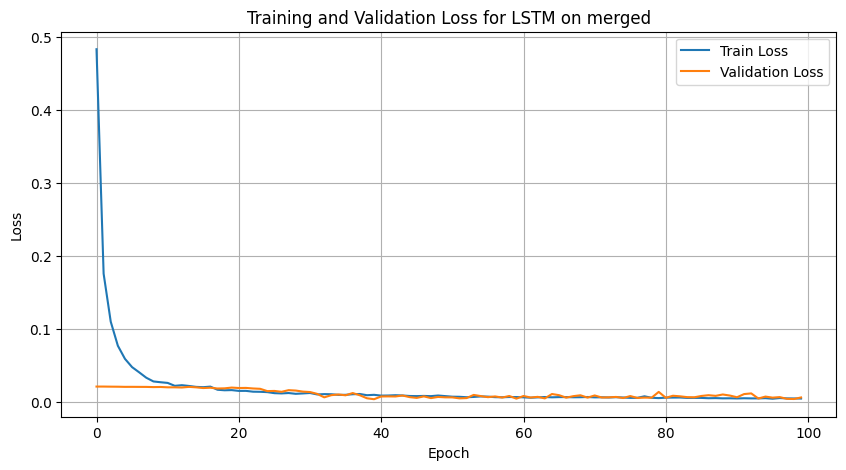

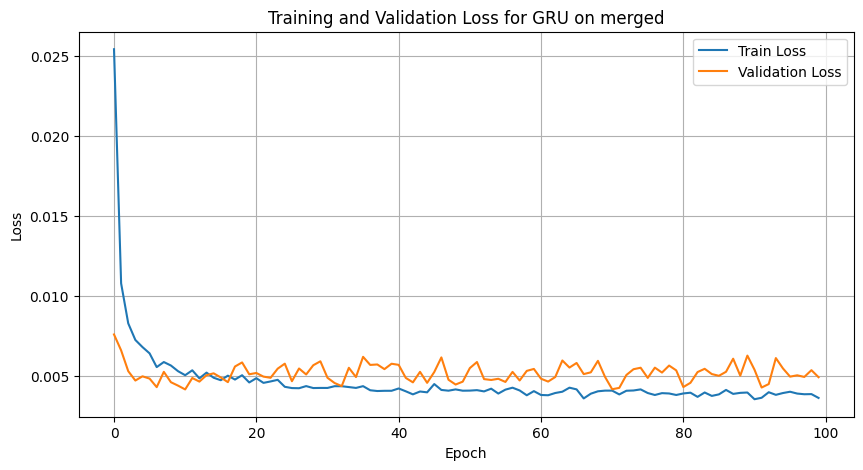

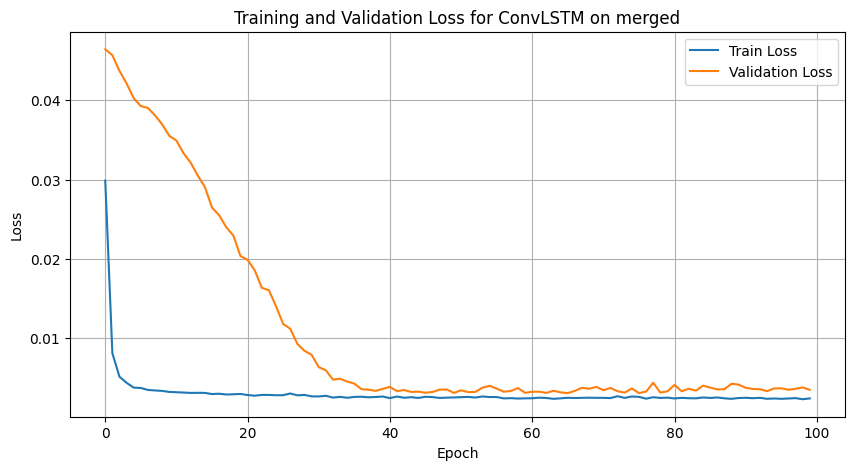

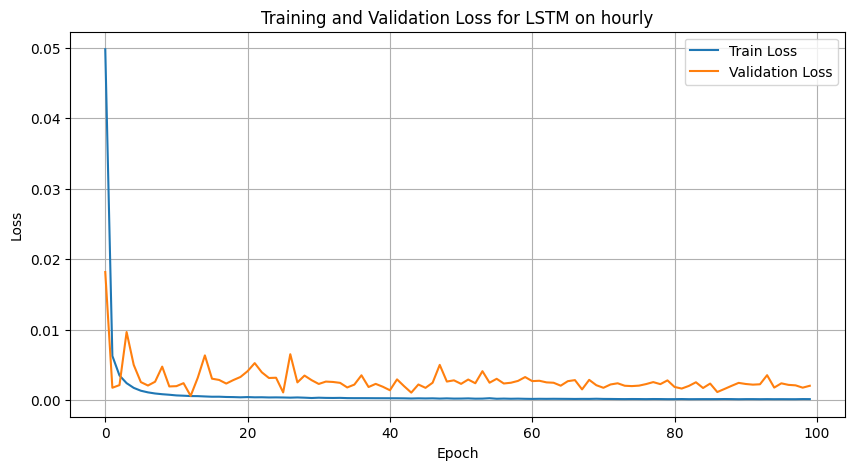

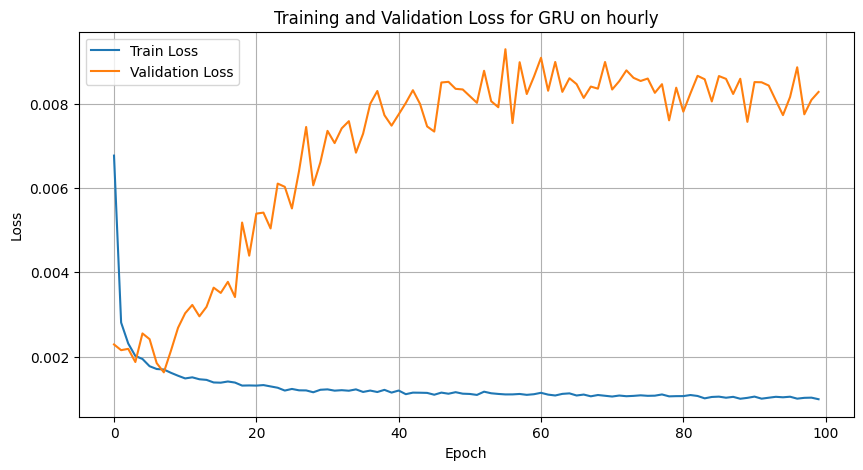

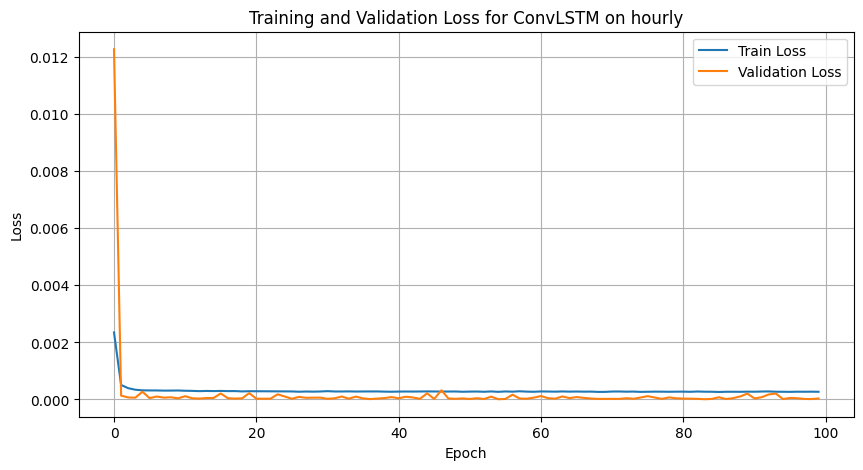

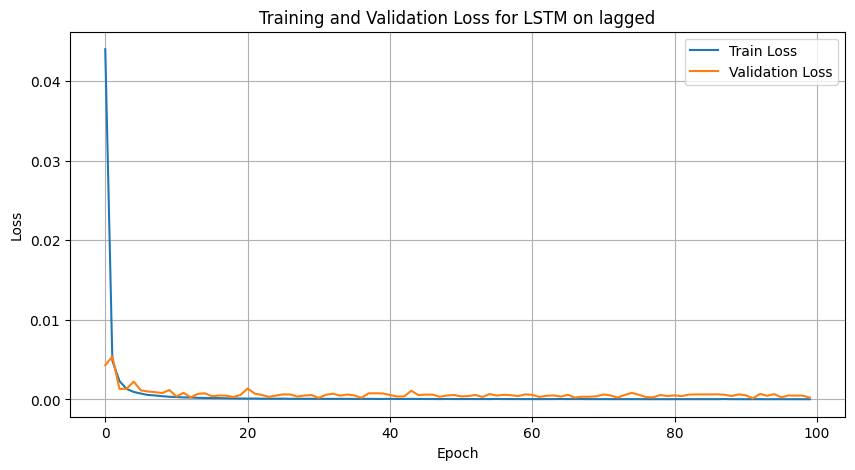

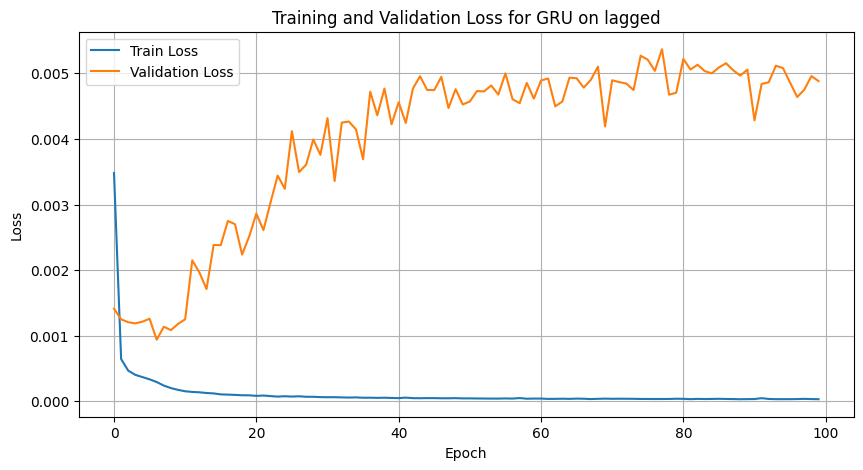

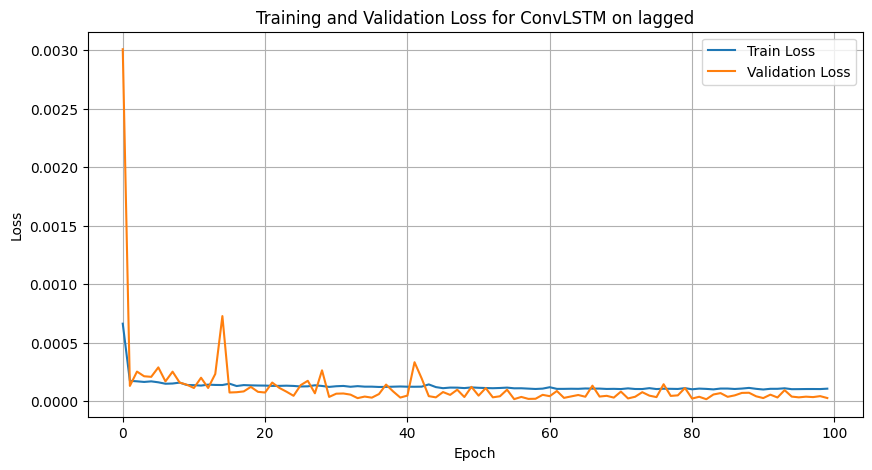

In [37]:
def plot_model_losses(results, dataset_name, model_name):
    history = results[(dataset_name, model_name)]['history']
    plt.figure(figsize=(10, 5))
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {model_name} on {dataset_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    #plt.text(1, 1, f'{results[(dataset_name, model_name)]["name"]}\nMAE: {results[(dataset_name, model_name)]["mae"]}')
    # plt.savefig(f'plots/{dataset_name}_{model_name}_loss.png')
    plt.show()

for dataset_name, model_name in results.keys():
    plot_model_losses(results, dataset_name, model_name) 
